In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import seaborn as sns

In [3]:
fixed = [False, True, False, False, True, False]

standard = jsm_mcmc.Chain("../../mcmc/simple_power_law/s15/alpha_permutations/mock_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=30)

fixed = [False, True, True, False, True, False]

beta = jsm_mcmc.Chain("../../../data/remote_pull/fiducial/model_0/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

fixed = [False, True, False, True, True, False]

gamma = jsm_mcmc.Chain("../../../data/remote_pull/fiducial/model_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

fixed = [False, True, False, False, True, True]

nu = jsm_mcmc.Chain("../../../data/remote_pull/fiducial/model_2/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

fixed = [True, True, False, False, True, False]

anchor = jsm_mcmc.Chain("../../../data/remote_pull/fiducial/model_3/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

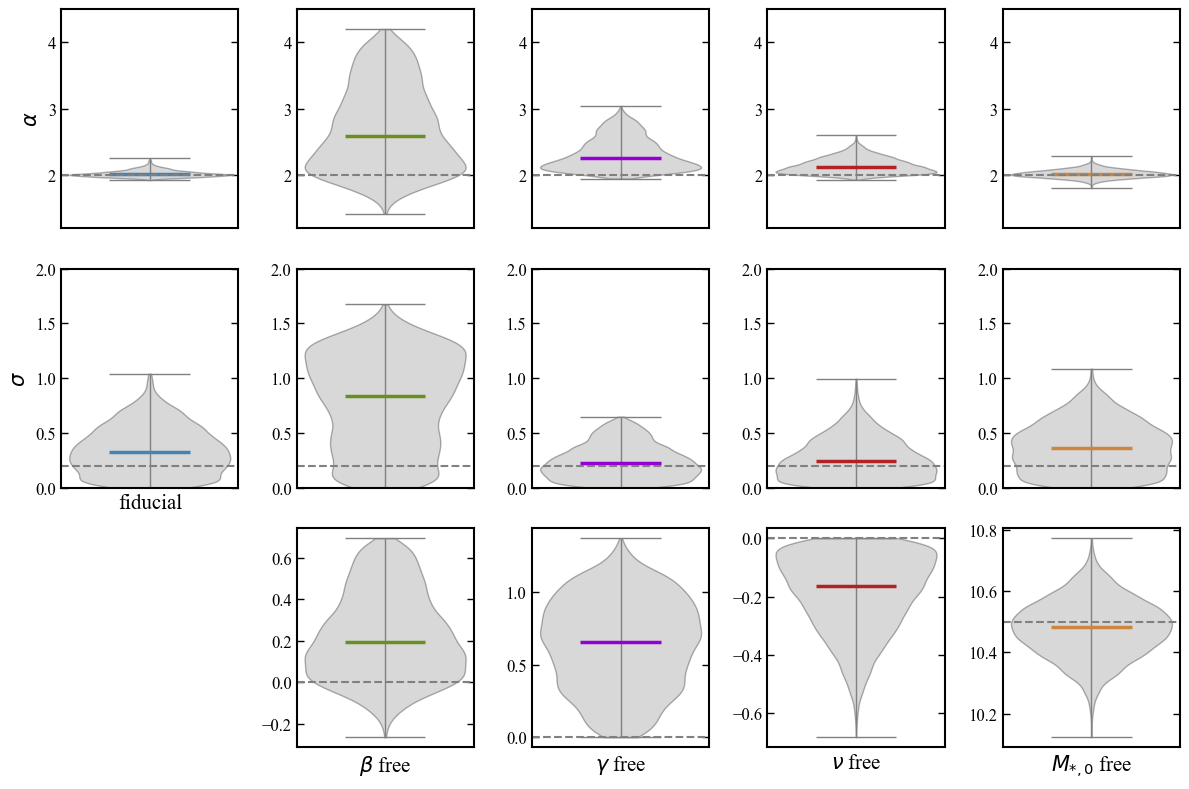

In [4]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'
plt.rc('legend',fontsize=15)

plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 12

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['font.family'] = 'Times New Roman'

# Remove ticks from the top and bottom of the plot
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.top'] = False

# Define quantiles
qaunts = [0.16, 0.5, 0.84]

# Define violin plot function
def violin_plot(ax, data, quantiles, color, ylim=None):
    violin = ax.violinplot(data, showmedians=True, showextrema=True)#, quantiles=quantiles)
    for pc in violin['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
    for partname in ('cmins', 'cmaxes', 'cbars', 'cmedians'):
        vp = violin[partname]
        vp.set_edgecolor(color if partname == 'cmedians' else 'grey')
        vp.set_linewidth(2.5 if partname == 'cmedians' else 1)
    if ylim is not None:
        ax.set_ylim(ylim)

truth_color = "grey"

# Create subplots
fig, axs = plt.subplots(ncols=5, nrows=3, sharex=True, figsize=(12, 8))

# Plot violins
violin_plot(axs[0, 0], standard.clean[:,0], qaunts, 'steelblue', (1.2, 4.5))
axs[0,0].axhline(2.0, color=truth_color, ls="--")
violin_plot(axs[1, 0], standard.clean[:,1], qaunts, 'steelblue', (0, 2.0))
axs[1,0].axhline(0.2, color=truth_color, ls="--")



violin_plot(axs[0, 1], beta.clean[:,0], qaunts, 'olivedrab', (1.2, 4.5))
axs[0,1].axhline(2.0, color=truth_color, ls="--")
violin_plot(axs[1, 1], beta.clean[:,2], qaunts, 'olivedrab', (0, 2.0))
axs[1,1].axhline(0.2, color=truth_color, ls="--")
violin_plot(axs[2, 1], beta.clean[:,1], qaunts, 'olivedrab')
axs[2,1].axhline(0.0, color=truth_color, ls="--")



violin_plot(axs[0, 2], gamma.clean[:,0], qaunts, 'darkviolet', (1.2, 4.5))
axs[0,2].axhline(2.0, color=truth_color, ls="--")
violin_plot(axs[1, 2], gamma.clean[:,1], qaunts, 'darkviolet', (0, 2.0))
axs[1,2].axhline(0.2, color=truth_color, ls="--")
violin_plot(axs[2, 2], gamma.clean[:,2], qaunts, 'darkviolet')
axs[2,2].axhline(0.0, color=truth_color, ls="--")


violin_plot(axs[0, 3], nu.clean[:,0], qaunts, 'firebrick', (1.2, 4.5))
axs[0,3].axhline(2.0, color=truth_color, ls="--")
violin_plot(axs[1, 3], nu.clean[:,1], qaunts, 'firebrick', (0, 2.0))
axs[1,3].axhline(0.2, color=truth_color, ls="--")
violin_plot(axs[2, 3], nu.clean[:,2], qaunts, 'firebrick')
axs[2,3].axhline(0.0, color=truth_color, ls="--")


violin_plot(axs[0, 4], anchor.clean[:,1], qaunts, 'peru', (1.2, 4.5))
axs[0,4].axhline(2.0, color=truth_color, ls="--")
violin_plot(axs[1, 4], anchor.clean[:,2], qaunts, 'peru', (0, 2.0))
axs[1,4].axhline(0.2, color=truth_color, ls="--")
violin_plot(axs[2, 4], anchor.clean[:,0], qaunts, 'peru')
axs[2,4].axhline(10.5, color=truth_color, ls="--")


# Customize axes and labels


axs[2, 1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

axs[2, 2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

axs[2, 3].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

axs[2, 4].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)


axs[1, 0].set_xlabel("fiducial")
axs[2, 1].set_xlabel("$\\beta$ free")
axs[2, 2].set_xlabel("$\\gamma$ free")
axs[2, 3].set_xlabel("$\\nu$ free")
axs[2, 4].set_xlabel("$M_{*,0}$ free")


axs[0, 0].set_ylabel("$\\alpha$")
axs[1, 0].set_ylabel("$\\sigma$")
# axs[2, 2].set_ylabel("$\\gamma$")
# axs[2, 3].set_ylabel("$\\nu$")
# axs[2, 4].set_ylabel("$M_{*,0}$")

# Remove ticks from the top and bottom of the plot
axs[2,0].axis("off")
plt.tight_layout()
plt.savefig("../../../paper_1/figures/feature_recovery/extra_freedom.pdf", bbox_inches="tight")
plt.show()

In [5]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

In [6]:
mass_example = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"][0]
red_example = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"][0]
halo_masses = np.linspace(8,12,100) # just for the model

In [7]:
def generate_plot(thetas, model_colors, model_names):

    import matplotlib.pyplot as plt
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = False
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rc('legend',fontsize=15)
    
    plt.rcParams['xtick.major.size'] = 5
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['xtick.top'] = True
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 12
    
    plt.rcParams['ytick.major.size'] = 5
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['ytick.right'] = True
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 12
    
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['xtick.top'] = True

    plt.figure(figsize=(8, 6))

    # plt.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="darkorange", ls="--", label="Behroozi 2013", lw=2)
    # plt.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="darkmagenta", ls="-.", label="Rodriguez-Puebla 2017", lw=2)
    
    for i,theta in enumerate(thetas):
        theta_det = [theta[0], theta[1], theta[2], theta[3], 0.0, 0.0]
        det = jsm_SHMR.general_new(theta_det, halo_masses, 0, 1)
        plt.plot(halo_masses, det, color=model_colors[i], label=model_names[i], lw=2)
        sigma = theta[4] + theta[5]*(halo_masses-12)
        plt.errorbar(11+(i/5), 7.5, yerr=sigma[70], capsize=5, marker='.', color=model_colors[i])
        # plt.fill_between(halo_masses, det - sigma, det + sigma, color=model_colors[i], alpha=0.05) 
        # plt.plot(halo_masses, det+sigma, color=model_colors[i], lw=0.4, ls="--")
        # plt.plot(halo_masses, det-sigma, color=model_colors[i], lw=0.4, ls="--")


    plt.ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$", fontsize=15)
    plt.xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$", fontsize=15)
    plt.ylim(6.5, 10.5)
    plt.xlim(9.8, 12)
    plt.legend(fontsize=15, loc=2)
    plt.tight_layout()
    plt.savefig('../../../paper_1/figures/updated/extra_freedom_SHMR.pdf', bbox_inches="tight")
    plt.show()

In [8]:
thetas = [[10.5, 2.0, 0.0, 0.0, 0.2, 0.0], [10.5, 2.59, 0.2, 0.0, 0.84, 0.0], [10.5, 2.26, 0.0, 0.22, 0.66, 0.0], [10.5, 2.12, 0.0, 0.0, 0.24, -0.16], [10.48, 2.02, 0.0, 0.0, 0.36, 0.0]]

model_colors = ["steelblue", 'olivedrab', 'darkviolet', 'firebrick', 'peru']

model_names = ["fiducial", "$\\beta$ free", "$\\gamma$ free", "$\\nu$ free", "$M_{*,0}$ free"]

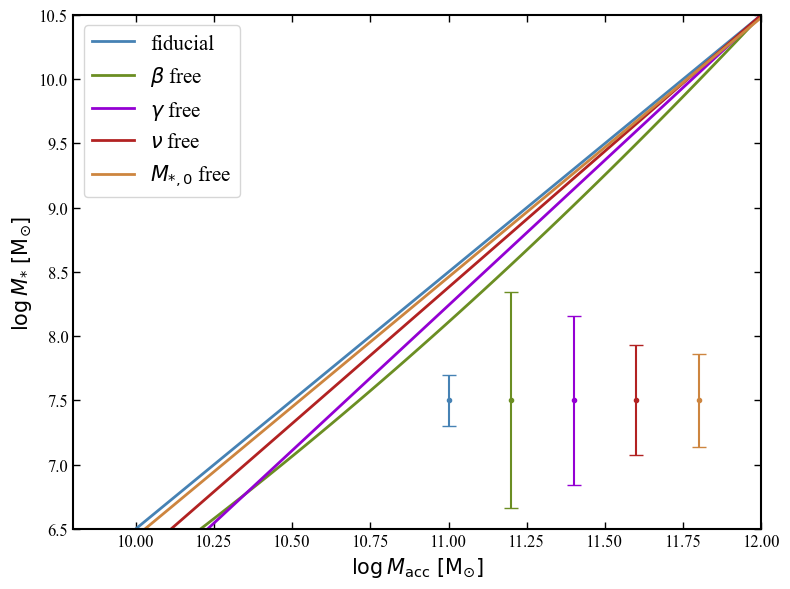

In [9]:
generate_plot(thetas, model_colors, model_names)